In [30]:
from utils import *
from probabilistic_models import *

## Loading Datasets

In [31]:
df_1 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor1.xlsx")
df_2 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor2.xlsx")

In [32]:
data = pd.concat([df_1, df_2], ignore_index=True)
df,df_dict = df_processor(data)

In [33]:
X_values = df['Inverse_Temp'].values
Y_values = df['Mpa'].values

## Plot Utils

In [34]:
def plot_different_cdf(model,cdf=[0.5,0.9,0.1,0.99,0.01]):
    temperature_values = np.linspace(10, 600, 100)
    fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(df_1["Temperature"], df_1["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 1")
    ax.scatter(df_2["Temperature"], df_2["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 2")

    for i in range(len(cdf)):
        ys_predicted_cdf = model.predict(cdf[i],temperature_values)
        ax.plot(temperature_values, ys_predicted_cdf, linestyle="-", linewidth=1, label=f"Predicted YS (CDF={cdf[i]})")


    ax.set_xlabel("Temperature (°C)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Yield Stress (YS)", fontsize=12, fontweight="bold")
    ax.set_title("Yield Stress vs. Temperature Comparison", fontsize=14, fontweight="bold")
    ax.legend()
    fig.show()

In [35]:
def line_fit_plot(model):
    plt.figure(figsize=(10, 6))

    for temp in df_dict.keys():
        data = df_dict[temp]["Mpa"].values
        data = np.sort(data)

        sigma_values, ln_sigma_values,sigma_fit_log, y_fit = model.transform(data)

        plt.scatter(sigma_values, ln_sigma_values, label=f"Temp {temp}")
        plt.plot(sigma_fit_log, y_fit, linestyle='-')

    plt.title(f" {model.name} Probability Plot with Fitted Line", fontsize=14, fontweight="bold")
    plt.xlabel("ln(Data)", fontsize=12)
    plt.ylabel("Standard Normal Quantile", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## Weibull Model

In [36]:
weibull = WeibullModel(X_values, Y_values)
weibull.intercept,weibull.slope, weibull.shape

(5.89755456074455, 0.02332859854794873, 25.755298576718157)

C:\Users\mohit\AppData\Local\Temp\ipykernel_2680\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


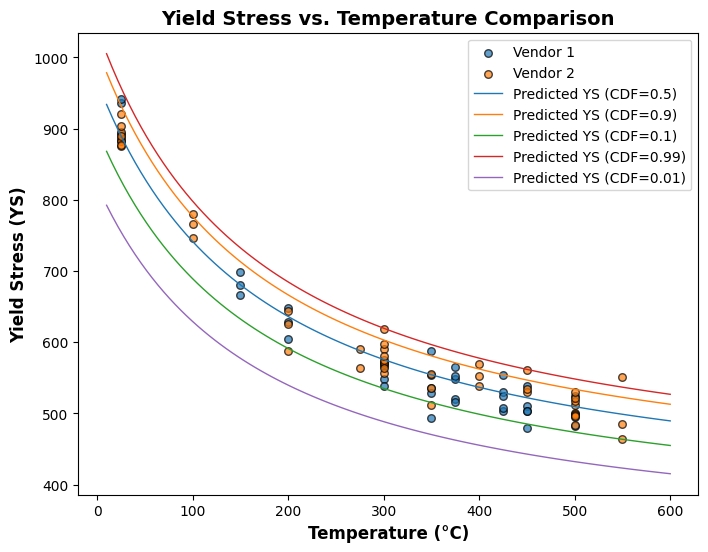

In [37]:
plot_different_cdf(weibull)

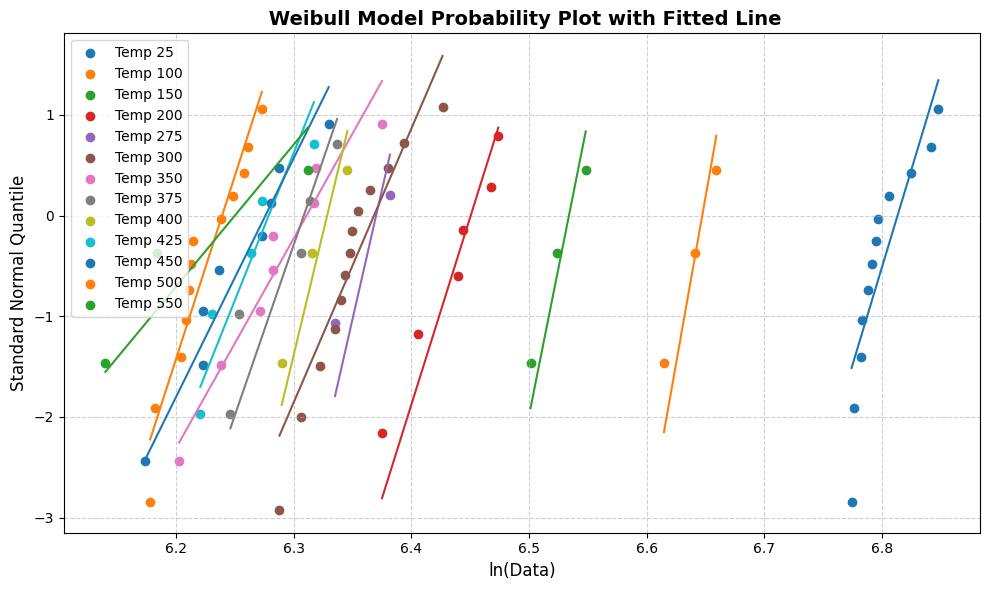

In [38]:
line_fit_plot(weibull)

## LogNormal Model

In [39]:
lognormal = LognormalModel(X_values, Y_values)
lognormal.k, lognormal.m, lognormal.sigma

(5.859842293281658, 0.024157582221448693, 0.03864222350319222)

C:\Users\mohit\AppData\Local\Temp\ipykernel_2680\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


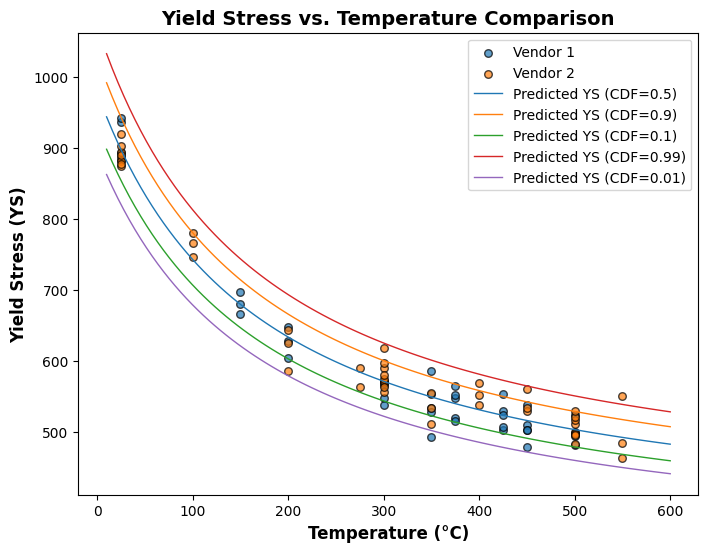

In [40]:
plot_different_cdf(lognormal)

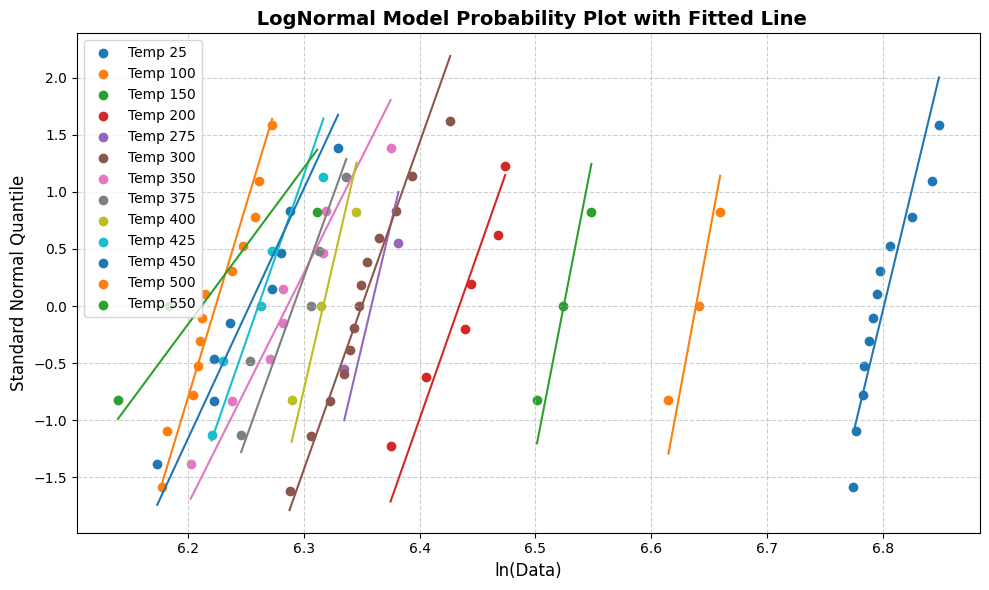

In [41]:
line_fit_plot(lognormal)

## Normal Model:

In [42]:
normal = NormalModel(X_values, Y_values)
normal.intercept,normal.slope, normal.sigma

(246.98596564552668, 16.471373826519844, 24.856314506080235)

C:\Users\mohit\AppData\Local\Temp\ipykernel_2680\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


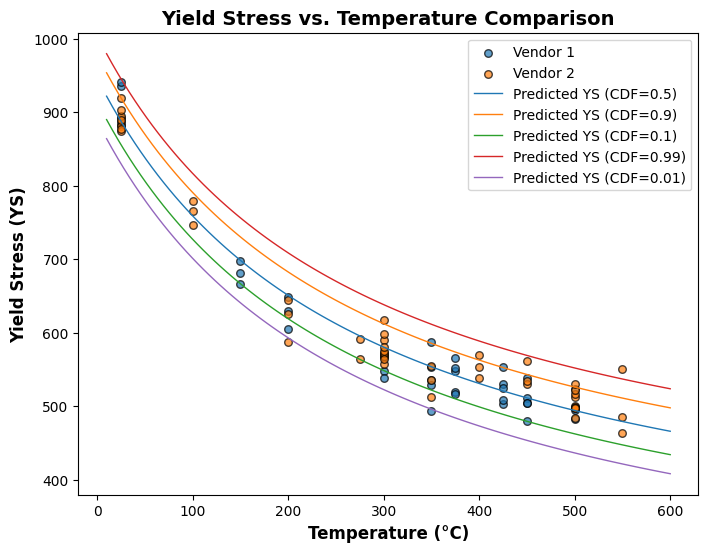

In [43]:
plot_different_cdf(normal)

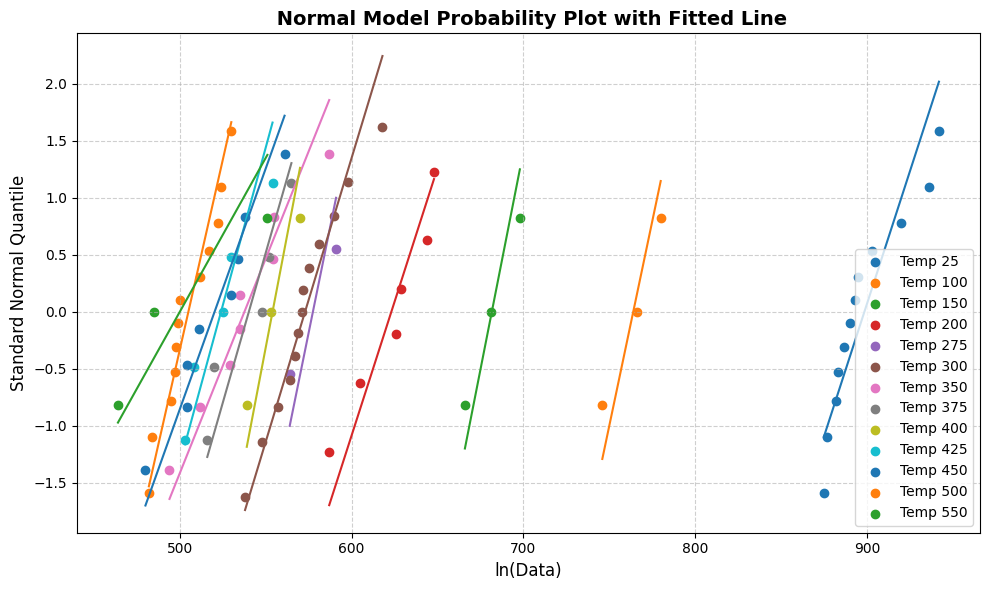

In [44]:
line_fit_plot(normal)

## Weibull (3-Parameters):

In [45]:
class WeibullModel3(ProbModel):
    def __init__(self,X_values, Y_values):
        self.X_values = X_values
        self.Y_values = Y_values
        self.name = "3-Parameter Weibull Model"
        self.minimize()

    def log_likelihood(self,params, temp, sigma_values):
        """Weibull regression model"""
        shape = params[0]
        u = params[1]
        w = params[2]
        loc = params[3]

        if shape <= 0:
            return np.inf
        scale = np.exp(u + w * temp)

        return -np.sum(stats.weibull_min.logpdf(sigma_values, c=shape, scale=scale, loc=loc))
    
    def minimize(self):
        init_params = [2.0, np.log(np.mean(self.Y_values)), 0.0,0.0]
        bounds = [(1e-6, None), (None, None), (None, None),(None,None)]

        result_regression = optimize.minimize(
            self.log_likelihood,
            init_params,
            args=(self.X_values, self.Y_values),
            bounds=bounds,
            method='L-BFGS-B'
        )

        self.shape, self.intercept, self.slope,self.delta = result_regression.x

    def predict(self,cdf, temperature_values):
        return np.exp(
            (self.intercept + (self.slope * 11604.53 / (temperature_values + 273.16))) +
            ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
        ) + self.delta
    
    @staticmethod
    def estimate_params(data):
        shape, loc, scale = stats.weibull_min.fit(data)  # Lock location to 0 for typical Weibull fitting
        return shape, scale, loc
    
    def transform(self, data):
        n = len(data)
        cdf_values = np.array([median_rank(n, i + 1) for i in range(n)])

        # Apply Weibull probability plot transformation
        sigma_values = np.log(data)  # X-axis: ln(data)
        wb_sigma_values = np.log(-np.log(1 - cdf_values))  # Y-axis: ln(-ln(1 - p))

        shape, scale,loc = self.estimate_params(data)

        # Generate fitted Weibull line
        sigma_line = np.linspace(min(data), max(data), 100)
        pred_sigma_line = np.log(-np.log(1 - stats.weibull_min.cdf(sigma_line, shape, scale=scale,loc=loc)))

        self.transform_y_label = "ln(-ln(1 - p))"  # name to be displayed in the y-axis of the graph

        return sigma_values, wb_sigma_values, np.log(sigma_line), pred_sigma_line
    
    @property
    def st_description(self):
        st.write("Equation: ")
        st.latex(r"\sigma_f = exp\left(\biggl\{U_t+\frac{W_t}{T}\biggl\}+\frac{1}{m}ln\left(ln\left(\frac{1}{1-f_w}\right)\right)\right)+\delta")
        st.write("Here: ")
        st.write(f"m (shape parameter) :  {self.shape:.6f}")
        st.write(f"$W_t$ (slope) :  {self.slope:.6f}")
        st.write(f"$U_t$ (intercept) :  {self.intercept:.6f}")

        return ''

In [46]:
wb3 = WeibullModel3(X_values, Y_values)

In [47]:
wb3.intercept, wb3.slope, wb3.shape, wb3.delta

(5.897288017681604,
 0.02333234865891837,
 25.750626771269683,
 0.10997053370533025)

C:\Users\mohit\AppData\Local\Temp\ipykernel_2680\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


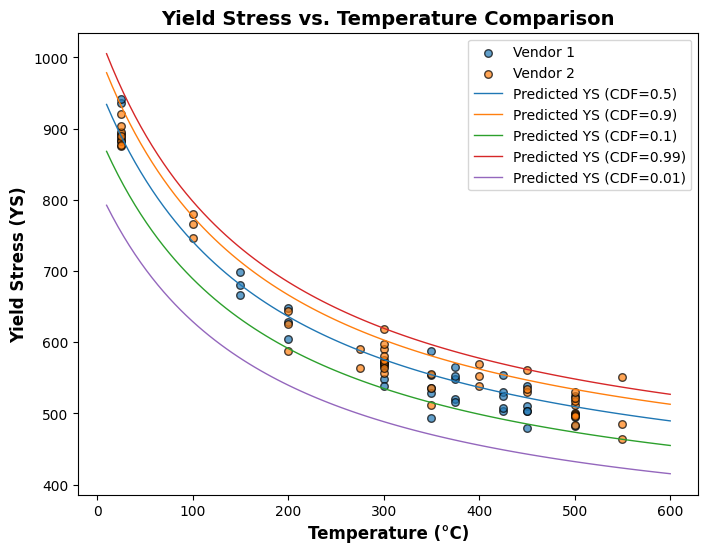

In [48]:
plot_different_cdf(wb3)

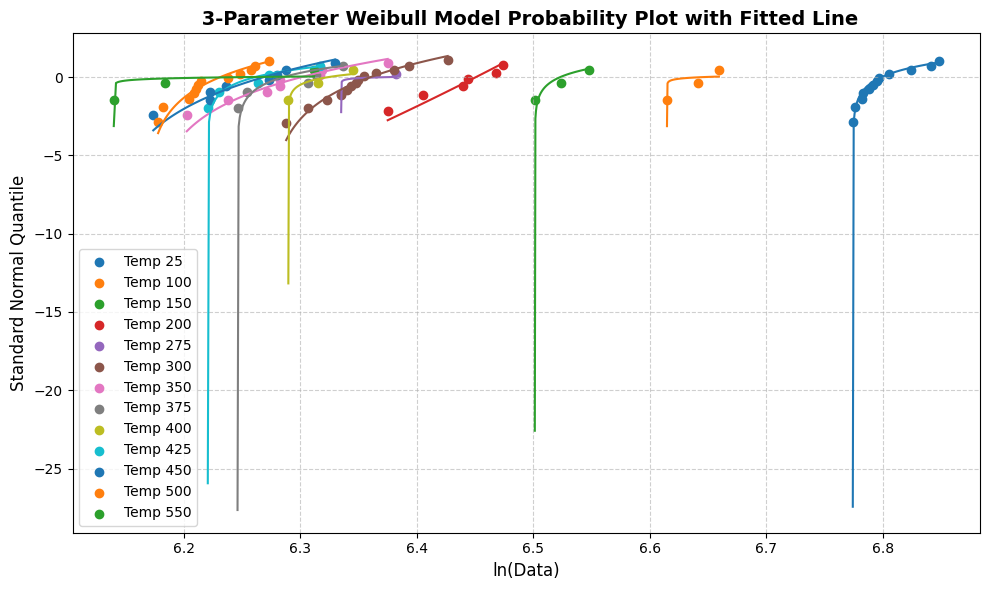

In [49]:
line_fit_plot(wb3)

## LogNormal3

In [50]:
class LognormalModel3(ProbModel):
    def __init__(self, X_values, Y_values):
        self.X_values = X_values
        self.Y_values = Y_values
        self.name = "3-Parameter LogNormal Model"

        self.minimize()

    def log_likelihood(self, params,temp, sigma_values):
        k,m, sigma,gamma = params
        if sigma <= 0:
            return np.inf  # Avoid invalid sigma
        
        mu = k + m * temp
        log_likelihood = np.sum(stats.norm.logpdf(np.log(sigma_values-gamma), loc=mu, scale=sigma) - np.log(sigma_values))
        return -log_likelihood  
    
    def minimize(self):
        init_params = [10, 1,1,1]
        bounds = [(None, None),(None, None), (1e-10, None),(None, None)]  # mu unbounded, sigma > 0
        result_lognormal = optimize.minimize(
            self.log_likelihood,
            init_params,
            args=(self.X_values, self.Y_values,),
            method='L-BFGS-B',
            bounds=bounds
        )

        self.k, self.m, self.sigma,self.gamma = result_lognormal.x

    def predict(self,cdf, temperature_values):
        z = np.sqrt(2) * self.sigma * erfinv(2 * cdf - 1)
        return np.exp(self.k + (self.m * 11604.53) / (temperature_values + 273.16) + z) + self.gamma
    
    @staticmethod
    def estimate_params(data):
        log_data = np.log(data)
        mu, sigma = np.mean(log_data), np.std(log_data, ddof=0)
        return mu, sigma
    
    def transform(self,data):
        n = len(data)
        cdf_values = np.array([median_rank(n, i + 1) for i in range(n)])

        # X-axis: ln(data), Y-axis: inverse CDF of normal
        sigma_values = np.log(data)
        pred_sigma_values = stats.norm.ppf(cdf_values)  # log(Normal quantile)

        mu, sigma = self.estimate_params(data)

        # Generate fitted line
        sigma_line = np.log(np.linspace(min(data), max(data), 100))

        pred_sigma_line = (sigma_line - mu) / sigma  # Standardized normal score
        # Above line is just a simplification of the below line
        # pred_sigma_line = stats.norm.ppf(stats.norm.cdf(sigma_fit_log, loc=mu,scale=sigma))

        self.transform_y_label = "Standard Normal Quantile"

        return sigma_values, pred_sigma_values, sigma_line, pred_sigma_line
    
    @property
    def st_description(self):
        st.write("Equation: ")
        st.latex(r"\sigma_f = \exp \left( \ln(\sigma_m) + \sqrt{2} \, \sigma_{sl} \, \text{erf}^{-1}(2f_{ln} - 1) \right)+\gamma")
        st.write("Here: ")
        st.write(f"$\sigma_{{sl}}$ (shape parameter) :  {self.sigma:.6f}")
        st.write(f"$M_t$ (slope) :  {self.m:.6f}")
        st.write(f"$K_t$ (intercept) :  {self.k:.6f}")

        return ''

In [51]:
lnm = LognormalModel3(X_values,Y_values)

In [52]:
lnm.k, lnm.m, lnm.sigma,lnm.gamma

(5.857359047818319,
 0.024193619099307603,
 0.038709313821760113,
 0.989605439499162)

C:\Users\mohit\AppData\Local\Temp\ipykernel_2680\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


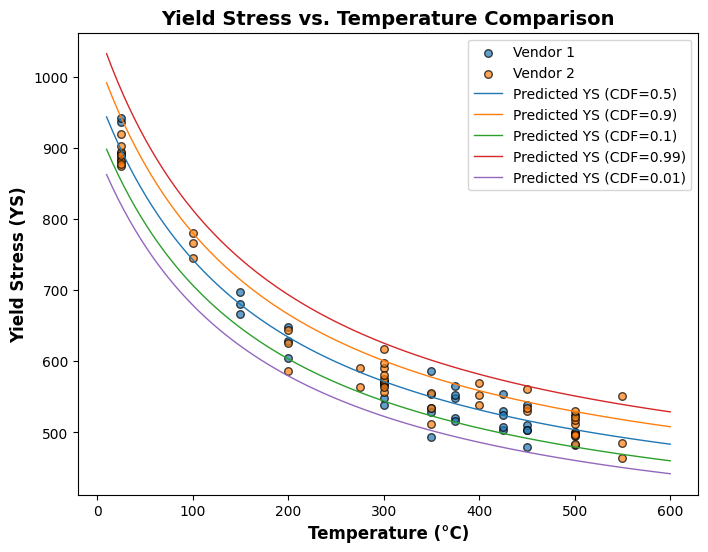

In [53]:
plot_different_cdf(lnm)

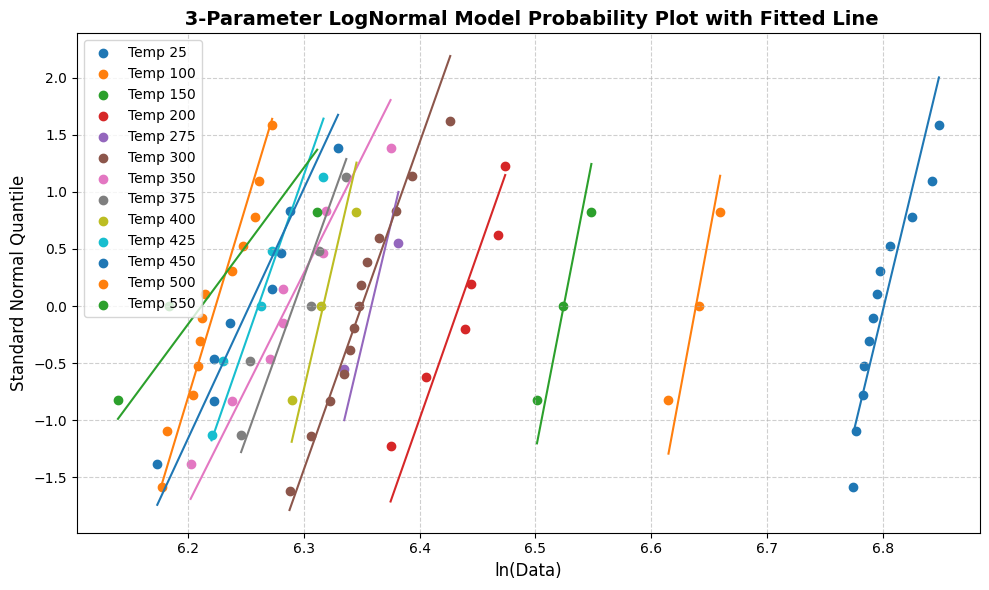

In [54]:
line_fit_plot(lnm)